##  Classification : Boosting

### Business Objective

    To identify products at risk of backorder before the event occurs so the business has time to react. 

#### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

#### Identify Right Error Metrics

    Based on the businees have to identify right error metrics.

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Loading the data with 20,000 Records

In [30]:
data = pd.read_csv("BackOrders.csv",nrows=20000,na_values=['$','#','Null'])

In [14]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,118,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


See the No. row and columns

In [10]:
data.shape

(20000, 23)

In [15]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

#### Train_Test_Split for Unseen Data concatinate train related and test related together and check shape of train and test

In [16]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(['went_on_backorder'],axis=1),
                                                 data['went_on_backorder'],test_size = 0.2,random_state=1)

train = pd.concat([X_train,y_train],axis=1).reset_index().drop(['index'],1)
test = pd.concat([X_test,y_test],axis=1).reset_index().drop(['index'],1)
print("TRAIN DATA SHAPE IS : ",train.shape)
print("TEST DATA SHAPE IS :",test.shape)

TRAIN DATA SHAPE IS :  (16000, 23)
TEST DATA SHAPE IS : (4000, 23)


#### Write a Function to remove the columns which have number of unique values more than 95% on Train and Test

In [36]:
def removeunique(data1):
    for i in data1.columns:
            if(data1[i].nunique()/data1.shape[0]>0.95):
                data1.drop(columns=i,inplace=True,axis=0)
            #train.nunique()/train.shape[0]   

In [39]:
removeunique(train)
removeunique(test)

#### Write a function checking  the total number of null values in train data if null values present in the train data then check and report the column names having null values impute with mean/median or mode on Train and Test

In [68]:
for col in train.columns:
    if(train[col].isna().any()):
        print(col)
        if(train[col].dtypes!='object'):
            train[col].fillna(train[col].mean(),inplace=True)
        else:
            

lead_time


In [69]:
train.isna().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [64]:
data.dtypes

national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Perform Encoding on Categorical Data convert target column to 'category' column and other string leteral columns to int on Train and Test

#### Train_Test_Split on Train Data

(22702, 21) (5676, 21)


In [605]:
train = pd.concat([X_train,y_train],axis=1).reset_index().drop(['index'],1)
test = pd.concat([X_test,y_test],axis=1).reset_index().drop(['index'],1)
print("TRAIN DATA SHAPE IS : ",train.shape)
print("TEST DATA SHAPE IS :",test.shape)

TRAIN DATA SHAPE IS :  (22702, 22)
TEST DATA SHAPE IS : (5676, 22)


Display data type of each variable

#### Function for Clipping on Outliers handling

### Train-Test Split on Train Data

#### Correlation on Numeric Data and analyze

## Defining Error Metrices

In [633]:

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted)
    train_precision= precision_score(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted)
    test_precision= precision_score(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [634]:
from sklearn.metrics import classification_report


def classifcation_report_train_test(y_train, y_train_pred, y_test, y_test_pred):

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
            =========================================
            ''')
    print(classification_report(y_train, y_train_pred))

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TEST DATA
            =========================================
            ''')
    print(classification_report(y_test, y_test_pred))

### BOOSTING

Boosting is a method for combining a series of simple individual models to create a more powerful model. 
<br>Start by fitting an initial model (mostly a tree) to the data. 
<br>Then build a second model that focuses on accurately predicting the cases where the first model performs poorly. 
<br>The combination of these two models is expected to be better than either model alone. 
<br>Repeat the process many times. 
<br>Each successive model attempts to correct for the shortcomings of the combined ensemble of all previous models.
<br>The best possible next model, when combined with previous models, minimizes the overall prediction error.

### ***ADABOOST ***

1. Assign every observation, X(i), with an initial weight value, w(i) = 1/n, 
Where n is the total number of observations.
2. Train a **weak** model. (Most often a decision tree).
3. For each observation:
 <br>3.1. If predicted **incorrectly**, w(i) is **increased**.
 <br>3.2. If predicted **correctly**, w(i) i **decreased**.
4. Train a new weak model where observations with greater weights are given more priority.
5. Repeat steps 3 and 4 until observatons are perfectly predicted or a preset number of trees are trained.

### ***Advantages***
AdaBoost is a powerful classification algorithm that has enjoyed practical success with applications in a wide variety of fields, such as biology, computer vision, and speech processing. 

Unlike other powerful classifiers, such as SVM, AdaBoost can achieve similar classification results with much less tweaking of parameters or settings (unless of course you choose to use SVM with AdaBoost). 
The user only needs to choose: 

(1) which weak classifier might work best to solve their given classification problem

(2) The number of boosting rounds that should be used during the training phase. It enables a user to add several weak classifiers to the family of weak classifiers that should be used at each round of boosting. The AdaBoost algorithm will select the weak classifier that works best at that round of boosting.

### ***Disadvantages***

AdaBoost can be sensitive to noisy data and outliers. In some problems, however, it can be less susceptible to the overfitting problem than most learning algorithms.

## AdaBoost on Random Sampling

In [635]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=50, random_state=0)

###  ***What is Light GBM?***
 
Light GBM is a gradient boosting framework that uses tree based learning algorithm.

### ***How it differs from other tree based algorithm?***

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

#### ***Below diagrams explain the implementation of LightGBM and other boosting algorithms.***

### Picture Representing how LGBM Works

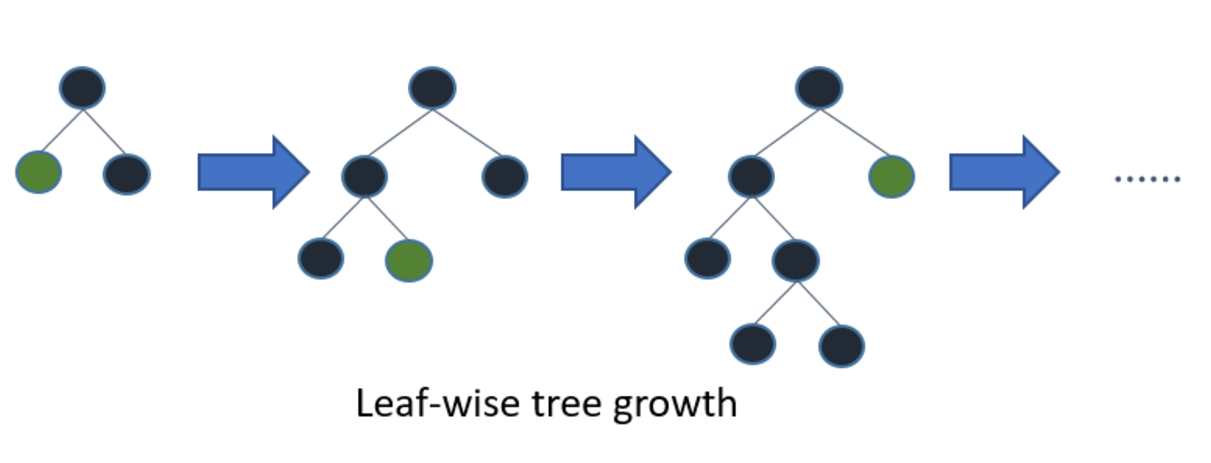

In [640]:
from IPython.display import Image
Image(filename='img/LGBM_Image.png',width = 800,height =800)

### Picture Representing how other GBM Algorithm Work

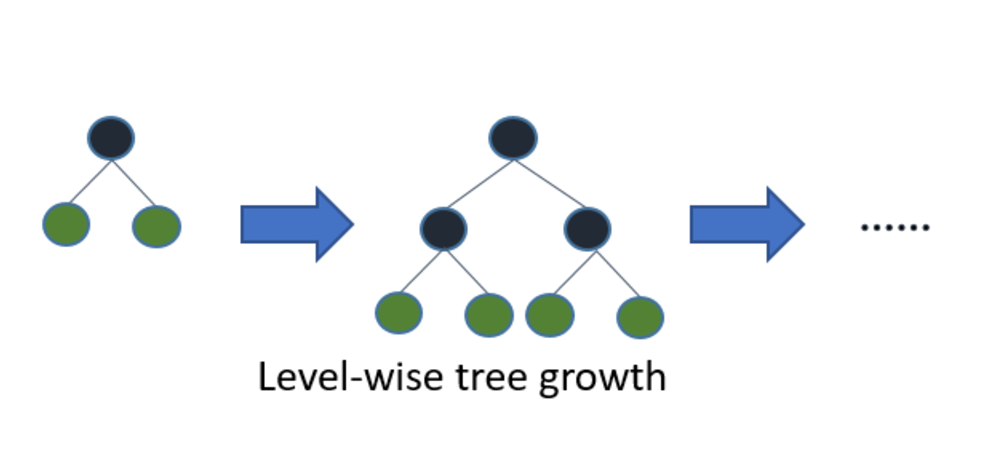

In [641]:
from IPython.display import Image
Image(filename='img/Light_GBM-2.png',width = 800,height =800)

### ***Why Light GBM is gaining extreme popularity?***

The size of data is increasing day by day and it is becoming difficult for traditional data science algorithms to give faster results. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.

### ***We briefly discussed the concept of Light GBM, now what about it’s implementation?***

Implementation of Light GBM is easy, the only complicated thing is parameter tuning. Light GBM covers more than 100 parameters but don’t worry, you don’t need to learn all.

It is very important for an implementer to know atleast some basic parameters of Light GBM. If you carefully go through following parameters of LGBM, I bet you will find this powerful algorithm a piece of cake.

## ***Parameters***
### Control Parameters

1) max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.

2) min_data_in_leaf: It is the minimum number of the records a leaf may have. The default value is 20, optimum value.  It is also used to deal over fitting

3) feature_fraction: Used when your boosting(discussed later) is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.

4) bagging_fraction: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.

5) early_stopping_round: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.

6) lambda: lambda specifies regularization. Typical value ranges from 0 to 1.

7) min_gain_to_split: This parameter will describe the minimum gain to make a split. It can used to control number of useful splits in tree.

8) max_cat_group: When the number of category is large, finding the split point on it is easily over-fitting. So LightGBM merges them into ‘max_cat_group’ groups, and finds the split points on the group boundaries, default:64

### ***Now, What are its Advantages?***

LightGBM as we already know is a gradient boosting framework that makes the use of tree-based learning algorithms. It is designed with the following advantages in order to be distributed as well as efficient:

Higher efficiency as well as faster training speed

Usage of lower memory

Better accuracy

Supports Parallel and GPU learning

Data of large-scale can be handled.

### ***Disadvantages:***

It is not advisable to use LGBM on small datasets. Also, Light GBM is sensitive to overfitting and can easily overfit small data. There is no threshold on the number of rows.

## LGBM on Random Sampling

In [642]:
#!pip install lightgbm

--- 0.12645196914672852 seconds ---


### ***GRADIENT BOOSTING***

Gradient boosting is a type of boosting. 

The key idea behind gradient boosting is to set the target outcomes for this next model in order to minimize the error. The target outcome for each case in the data set depends on how much a change in that case’s prediction impacts the overall prediction error.

If, for case X(i), a small change in the prediction causes a large drop in error, then the next target outcome is a high value. Predictions from the new model that are close to its targets will reduce the error.

If, for case X(j), a small change in the prediction causes no change in error, then the next target outcome is zero because changing this prediction does not decrease the error.

The name gradient boosting arises because of setting target outcomes based on the gradient of the error with respect to the prediction of each case. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case.

1. Initialize the outcome
2. Iterate from 1 to total number of trees
  <br>2.1 Update the weights for targets based on previous run (higher for the ones mis-classified)
  <br>2.2 Fit the model on selected subsample of data
  <br>2.3 Make predictions on the full set of observations
  <br>2.4 Update the output with current results taking into account the learning rate
3. Return the final output.

## ***Advantages***

1) Often provides predictive accuracy that cannot be beat.

2) Lots of flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.

3) No data pre-processing required - often works great with categorical and numerical values as is.

4) Handles missing data - imputation not required.

## ***Disadvantages***
1) GBM will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting. Must use cross-validation to neutralize.

2) Computationally expensive - GBMs often require many trees (>1000) which can be time and memory exhaustive.

3) The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.). This requires a large grid search during tuning.

4) Less interpretable although this is easily addressed with various tools (variable importance, partial dependence plots, LIME, etc.).

## GBM on Random Sampling

--- 0.03756999969482422 seconds ---


### ***XGBoost***


XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm.

Generally, XGBoost is fast. Really fast when compared to other implementations of gradient boosting.
#### The XGBoost Advantage
-  Regularization:
    -  Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
    -  In fact, XGBoost is also known as ‘regularized boosting‘ technique.
-  Parallel Processing:
    -  XGBoost implements parallel processing and is blazingly faster as compared to GBM.
    -  Boosting is sequential process that each tree can be built only after the previous one, and it  can be parallelized with making a tree using all cores. Refer. http://zhanpengfang.github.io/418home.html
    
    -  XGBoost also supports implementation on Hadoop.
-  High Flexibility
    -  XGBoost allow users to define custom optimization objectives and evaluation criteria.
    -  This adds a whole new dimension to the model and there is no limit to what we can do.
-  Handling Missing Values
    -  XGBoost has an in-built routine to handle missing values.
    -  User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
-  Tree Pruning:
    -  A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
    -  XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
    -  Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
-  Built-in Cross-Validation
    -  XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
    -  This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
-  Continue on Existing Model
    -  User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
    -  GBM implementation of sklearn also has this feature so they are even on this point.

## XGBoost on Random Sampling

--- 0.08398795127868652 seconds ---


## ***What Is Stratified Random Sampling?***
Stratified random sampling is a method of sampling that involves the division of a population into smaller sub-groups known as strata. In stratified random sampling or stratification, the strata are formed based on members' shared attributes or characteristics such as income or educational attainment.

Stratified random sampling is also called proportional random sampling or quota random sampling.

### ***How Stratified Random Sampling Works***
A stratified random sampling involves dividing the entire population into homogeneous groups called strata 
(plural for stratum). Random samples are then selected from each stratum.

### ***Key Takeaways***

1) Stratified random sampling allows researchers to obtain a sample population that best represents the entire population being studied.

2) Stratified random sampling involves dividing the entire population into homogeneous groups called strata.

3) Stratified random sampling differs from simple random sampling, which involves the random selection of data from an entire population, so each possible sample is equally likely to occur.

### ***Advantages of Stratified Random Sampling***
The main advantage of stratified random sampling is that it captures key population characteristics in the sample. Similar to a weighted average, this method of sampling produces characteristics in the sample that are proportional to the overall population. 

Stratified random sampling works well for populations with a variety of attributes but is otherwise ineffective if subgroups cannot be formed.

Stratification gives a smaller error in estimation and greater precision than the simple random sampling method. The greater the differences between the strata, the greater the gain in precision.

### ***Disadvantages of Stratified Random Sampling***

Unfortunately, this method of research cannot be used in every study. 

The method's disadvantage is that several conditions must be met for it to be used properly. 

Researchers must identify every member of a population being studied and classify each of them into one, and only one, subpopulation. 

As a result, stratified random sampling is disadvantageous when researchers can't confidently classify every member of the population into a subgroup. Also, finding an exhaustive and definitive list of an entire population can be challenging.

Overlapping can be an issue if there are subjects that fall into multiple subgroups. 

When simple random sampling is performed, those who are in multiple subgroups are more likely to be chosen. The result could be a misrepresentation or inaccurate reflection of the population.

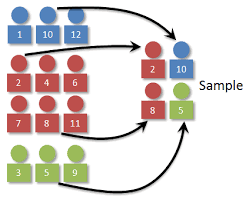

In [656]:
from IPython.display import Image
Image(filename='img/Startified_Samplimg2.png',width = 600,height =600)

## Stratified Random Sampling

Train: [ 2729  8023  7198 ... 21745 13798  9206] Test: [  953 22595  5499 ...   769  7855  7402]
Train: [12941 17597 22691 ... 22529 10858 11665] Test: [20262 20304 15503 ... 15422 18004  1071]
Train: [ 1867 21196 17760 ... 22086 22262  5426] Test: [10198  6654 12506 ...  4293 10012 14176]
Train: [  330  7786  7762 ... 14050  4569 20263] Test: [13992 11609 17591 ... 17793  8060 20416]
Train: [18281  9202  8081 ...  1061 10770 12525] Test: [ 3828 11678 14524 ... 18734 10075 21433]


### ABC on Stratified Sampling

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=50, random_state=0)

## LGBM on Stratified Sampling

--- 0.08066105842590332 seconds ---


## GBM on Startified Sampling

--- 0.0290679931640625 seconds ---


## XGBM on Stratified Sampling

--- 0.08390283584594727 seconds ---


## ***Cluster Sampling***

In cluster sampling, instead of selecting all the subjects from the entire population right off, the researcher takes several steps in gathering his sample population.

Researcher selects groups or clusters, and then from each cluster, the researcher selects the individual subjects by either simple random sampling. The researcher can even opt to include the entire cluster and not just a subset from it.

### ***Types of Cluster Sample***

#### One-Stage Cluster Sample
One-stage cluster sample occurs when the researcher includes all the samples from all the randomly selected clusters as sample.

#### Two-Stage Cluster Sample
Two-stage cluster sample is obtained when the researcher only selects a number of samples from each cluster by using simple or systematic random sampling.

### ***Advantages***

This sampling technique is cheap, quick and easy. Instead of sampling an entire country when using simple random sampling, the researcher can allocate his limited resources to the few randomly selected clusters or areas when using cluster samples.

The researcher can also increase his sample size with this technique. Considering that the researcher will only have to take the sample from a number of areas or clusters, he can then select more subjects since they are more accessible.

### ***Disadvantages***

From all the different type of probability sampling, this technique is the least representative of the population. The tendency of individuals within a cluster is to have similar characteristics and with a cluster sample, there is a chance that the researcher can have an overrepresented or underrepresented cluster which can skew the results of the study.

This is also a probability sampling technique with a possibility of high sampling error. This is brought by the limited clusters included in the sample leaving off a significant proportion of the population unsampled.

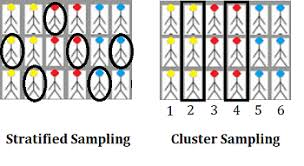

In [676]:
from IPython.display import Image
Image(filename='img/Stratified_vs_Cluster.png',width = 800,height =800)

### Train-Test Split

In [677]:
X_train_clustered1,X_test_clustered1,y_train_clustered1,y_test_clustered1 = train_test_split(train.iloc[:,:-1],train['went_on_backorder'],test_size = 0.2,random_state = 42)
print(X_train_clustered1.shape, X_test_clustered1.shape)

(18161, 21) (4541, 21)


#### Use K-Means for Cluster Sampling

In [680]:
X_train_Clusters = kmeans.predict(X_train_clustered1.values)
X_test_Clusters = kmeans.predict(X_test_clustered1.values)
X_test_Clusters_unseen = kmeans.predict(X_test.values)

In [681]:
train_kmeans = pd.concat([X_train_clustered1.reset_index(drop=True),pd.DataFrame(X_train_Clusters)], axis=1)
test_kmeans = pd.concat([X_test_clustered1.reset_index(drop=True),pd.DataFrame(X_test_Clusters)],axis = 1)
unseen_test = pd.concat([X_test.reset_index(drop=True),pd.DataFrame(X_test_Clusters_unseen)],axis = 1)

In [682]:
train_kmeans = train_kmeans.rename(columns = {0:"k_means_cluster"})
test_kmeans = test_kmeans.rename(columns = {0:"k_means_cluster"})
unseen_test = unseen_test.rename(columns = {0:"k_means_cluster"})

#### Check for Value Counts for Train-Test Split

### Ada Boost on Cluster Sampling

### LGBM on Cluster Sampling

--- 0.18656396865844727 seconds ---


### GBM on Cluster Sampling

### Cluster Sampling on XGBM

### Grid Search on LGBM

In [707]:
gridParams = {
    'learning_rate': [0.005, 0.01,0.1,0.3],# shrinkage rate at which model learns
    'n_estimators': [50,100,150],# Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],# mentionong objective as binary classification Model
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],# Random number seed.
    'colsample_bytree' : [0.64, 0.65, 0.66],# Subsample ratio of columns when constructing each tree.
    'subsample' : [0.7,0.75,0.8],# Subsample ratio of the training instance.
    'reg_alpha' : [1,1.2],# L1 regularization term on weights
    'reg_lambda' : [1,1.2,1.4],# L2 regularization term on weights
    }
grid = GridSearchCV()

#### Print the best parameters found